In [21]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [5]:
os.getcwd()

'/Users/Gerard/Desktop/python_project'

# Importing the data

In [230]:
dataset1 = pd.read_csv('GlobalLandTemperaturesByCity.csv',index_col=['dt'])

In [231]:
dataFrame=pd.DataFrame(dataset1)
dataFrame.shape

(8599212, 6)

In [232]:
DublinData = dataFrame[dataFrame["City"]=="Dublin"]
print(DublinData.head())

            AverageTemperature  AverageTemperatureUncertainty    City  \
dt                                                                      
1743-11-01               6.801                          1.944  Dublin   
1743-12-01                 NaN                            NaN  Dublin   
1744-01-01                 NaN                            NaN  Dublin   
1744-02-01                 NaN                            NaN  Dublin   
1744-03-01                 NaN                            NaN  Dublin   

            Country Latitude Longitude  
dt                                      
1743-11-01  Ireland   53.84N     6.82W  
1743-12-01  Ireland   53.84N     6.82W  
1744-01-01  Ireland   53.84N     6.82W  
1744-02-01  Ireland   53.84N     6.82W  
1744-03-01  Ireland   53.84N     6.82W  


In [27]:
x=DublinData["dt"]
y=DublinData["AverageTemperature"]

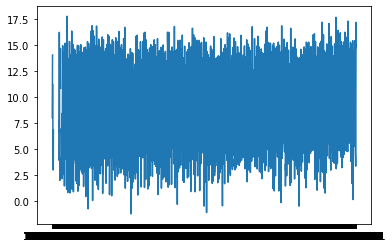

In [32]:
fig,ax = plt.subplots()
ax.plot(x,y)
plt.show()

# Using loc and iloc on dataFrame

In [50]:
DublinData.loc["1743-11-01",:]

AverageTemperature                 6.801
AverageTemperatureUncertainty      1.944
City                              Dublin
Country                          Ireland
Latitude                          53.84N
Longitude                          6.82W
Name: 1743-11-01, dtype: object

In [52]:
DublinData.iloc[100,:]

AverageTemperature                 6.508
AverageTemperatureUncertainty      1.934
City                              Dublin
Country                          Ireland
Latitude                          53.84N
Longitude                          6.82W
Name: 1752-03-01, dtype: object

In [64]:
DublinData[DublinData["AverageTemperature"] > 17]

,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
dt,,,,,,
1757-07-01,17.739,6.098,Dublin,Ireland,53.84N,6.82W
1983-07-01,17.166,0.310,Dublin,Ireland,53.84N,6.82W
1989-07-01,17.036,0.298,Dublin,Ireland,53.84N,6.82W
1995-08-01,17.643,0.237,Dublin,Ireland,53.84N,6.82W
2006-07-01,17.275,0.252,Dublin,Ireland,53.84N,6.82W
2013-07-01,17.149,0.626,Dublin,Ireland,53.84N,6.82W


In [68]:
dataFrame[dataFrame["Country"]=="Ireland"]['City'].unique()

array(['Cork', 'Dublin'], dtype=object)

In [71]:
dataFrame[dataFrame["Country"]=="Ireland"].groupby('City')["AverageTemperature"].max()

City
Cork      18.740
Dublin    17.739
Name: AverageTemperature, dtype: float64

In [74]:
DublinData[DublinData.isna()['AverageTemperature']==True]

,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
dt,,,,,,
1743-12-01,NaN,NaN,Dublin,Ireland,53.84N,6.82W
1744-01-01,NaN,NaN,Dublin,Ireland,53.84N,6.82W
1744-02-01,NaN,NaN,Dublin,Ireland,53.84N,6.82W
1744-03-01,NaN,NaN,Dublin,Ireland,53.84N,6.82W
1744-08-01,NaN,NaN,Dublin,Ireland,53.84N,6.82W
...,...,...,...,...,...,...
1752-06-01,NaN,NaN,Dublin,Ireland,53.84N,6.82W
1752-07-01,NaN,NaN,Dublin,Ireland,53.84N,6.82W
1752-08-01,NaN,NaN,Dublin,Ireland,53.84N,6.82W


# Forward Fill data

In [75]:
DublinDataFF = DublinData.fillna(method='ffill')

,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
dt,,,,,,
1743-11-01,6.801,1.944,Dublin,Ireland,53.84N,6.82W
1743-12-01,6.801,1.944,Dublin,Ireland,53.84N,6.82W
1744-01-01,6.801,1.944,Dublin,Ireland,53.84N,6.82W
1744-02-01,6.801,1.944,Dublin,Ireland,53.84N,6.82W
1744-03-01,6.801,1.944,Dublin,Ireland,53.84N,6.82W
...,...,...,...,...,...,...
2013-05-01,9.988,0.384,Dublin,Ireland,53.84N,6.82W
2013-06-01,13.384,0.185,Dublin,Ireland,53.84N,6.82W
2013-07-01,17.149,0.626,Dublin,Ireland,53.84N,6.82W


# Drop Missing Values

In [77]:
DublinData.dropna()

,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
dt,,,,,,
1743-11-01,6.801,1.944,Dublin,Ireland,53.84N,6.82W
1744-04-01,8.008,2.460,Dublin,Ireland,53.84N,6.82W
1744-05-01,9.684,1.615,Dublin,Ireland,53.84N,6.82W
1744-06-01,12.960,1.683,Dublin,Ireland,53.84N,6.82W
1744-07-01,14.018,1.684,Dublin,Ireland,53.84N,6.82W
...,...,...,...,...,...,...
2013-04-01,6.929,0.552,Dublin,Ireland,53.84N,6.82W
2013-05-01,9.988,0.384,Dublin,Ireland,53.84N,6.82W
2013-06-01,13.384,0.185,Dublin,Ireland,53.84N,6.82W


Function to update the missing values with the average value for that specific month

In [ ]:
def cleaning_data(column,df):
    
    

In [238]:
DublinData=DublinData.reset_index()
DublinData['dt'] = pd.to_datetime(DublinData['dt'])

In [234]:
DublinData.isna().any()

dt                               False
AverageTemperature                True
AverageTemperatureUncertainty     True
City                             False
Country                          False
Latitude                         False
Longitude                        False
dtype: bool

In [241]:
dictionary = (DublinData.isna().any()==True).to_dict()
null_cols = []
for col,v in dictionary.items():
    
    if v == True:
        null_cols.append(col)
        null_list = DublinData[DublinData.isna()[col]==True]
        index = []
        for i in range (0,len(null_list)):
            month = DublinData.loc[i,'dt'].to_pydatetime().month
            mean = DublinData[DublinData["dt"].dt.month == month].dropna()[col].mean()
            DublinData.at[i,col]=mean
            
